# Assignment 3

# Variational Dropout Sparsifies Deep Neural Networks

The Variational Dropout ( https://arxiv.org/abs/1506.02557 ) provides a Bayesian interpretation of conventional dropout procedure. Later it was shown that Variational Dropout can be used for model sparsification (Sparse VD), the effect can be achieved by via optimization of variational lower bound wrt individual dropout rates for every weight of the model ( https://arxiv.org/abs/1701.05369 ).

#### Sparse VD

Sparse VD model optimizes VLB $\mathcal{L}(\phi)$ with respect to parameters $\phi$ of a variational approximation $q_\phi(w)$:

$$\mathcal{L}(\phi) =  L_\mathcal{D}(\phi) - D_{KL}(q_\phi(w)\,\|\,p(w)) \to\max_{\phi\in\Phi}$$
$$L_\mathcal{D}(\phi) = \sum_{n=1}^N \mathrm{E}_{q_\phi(w)}[\log p(y_n\,|\,x_n, w)],$$

where $p(w)$ is the log-uniform prior distibution, the variational approxinmation $q_\phi(w)$ is a fullly factorized gaussian, the likelihood $p(y\,|\,x, w)$ is defined by a neuralnework with parametrs $w$. The optimization is performed by stohasic optimization methods e.g., Adam, etc.

For more convenience computing, the KL divergence is approximated as follows:
\begin{equation}
\begin{gathered}
    -D_{KL}(q(w_{ij}\,|\,\theta_{ij}, \alpha_{ij})\,\|\,p(w_{ij})) \approx
    \\
    \approx k_1\sigma(k_2 + k_3\log \alpha_{ij})) - 0.5\log(1+\alpha_{ij}^{-1}) + \mathrm{C}
    \label{eq:KL}\\
    k_1=0.63576~~~~~k_2=1.87320~~~~~k_3=1.48695
\end{gathered}
\end{equation}

**Note:** In the paper two parametrizations of q are used. The fist one is $\phi_i=\{\mu_{i}, \sigma_i\}$ that means $w_{ij} \sim N(w_{ij} | \mu_{ij}, \sigma^2_{ij})$ and the second one is $\phi_{ij}=\{\mu_{ij}, \alpha_{ij}\}$ that means $w_{ij} \sim N(w_{ij} | \mu_{ij}, \alpha_{ij}\mu^2_{ij})$. This two parametrization are connected as $\sigma^2_{ij} = \alpha_{ij}\mu^2_{ij}$. Do not be confused.


# In this assignment:
1. Implementation of fully-connected Sparse VD layer
2. Training Lenet-300-100 on MNIST dataset
3. Optional Research Assignment

Additional information:
- If you have a problem with importing logger, download logger.py and file to the same folder and run a notebook from it
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib), tabulate
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 3, 2018"

In [1]:
import math
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# I've coppied logger.py and renamed it to logger_.py to avoid conflicts with python site-package logger
from logger_ import Logger
from torch.nn import Parameter
from torch.autograd import Variable
from torchvision import datasets, transforms

## Implementation of  Sparse VD layer

In [2]:
class LinearSVDO(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearSVDO, self).__init__()
        """
            in_features: int, a number of input features
            out_features: int, a number of neurons
            threshold: float, a threshold for clipping weights
        """

        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        # torch.nn.parameter.Parameter of size out_features x in_features
        self.mu = torch.nn.Parameter(torch.zeros(out_features, in_features))

        # torch.nn.parameter.Parameter of size out_features x in_features
        self.log_sigma = torch.nn.Parameter(torch.zeros(out_features, in_features))

        # torch.nn.parameter.Parameter of size 1 x out_features
        self.bias = torch.nn.Parameter(torch.zeros(1, out_features))
        self.log_alpha = torch.zeros(out_features, in_features)
        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.zero_()
        self.mu.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)

    def forward(self, x):
        # x is a torch.Tensor of shape (?number_of_objects, in_features)
        # log_alpha is a torch.Tensor of shape (out_features, in_features)
        # Compute using self.log_sigma and self.mu
        self.log_alpha = 2 * (self.log_sigma - torch.log(torch.abs(self.mu) + 1e-8))
        # clipping for a numerical stability
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10)

        if self.training:
            # lrt_mean is a torch.Tensor of shape (x.shape[0], out_features)
            # compute mean activation using LRT

            lrt_mean = torch.mm(x, torch.transpose(self.mu, 0, 1)) + self.bias
            # lrt_std is a torch.Tensor of shape (x.shape[0], out_features)
            # compute std of activations unsig lrt,
            # do not forget use torch.sqrt(x + 1e-8) instead of torch.sqrt(x)
            lrt_var = torch.mm(x ** 2, torch.transpose(torch.exp(self.log_alpha) * self.mu ** 2, 0, 1))
            lrt_std = torch.sqrt(lrt_var + 1e-8)

            # eps is a torch.Tensor of shape (x.shape[0], out_features)
            eps = torch.randn(x.shape[0], self.out_features) # sample of noise for reparametrization
            return eps * lrt_std + lrt_mean # sample of activation

        # compute the output of the layer
        self.mask_nonzero_components_bin = self.log_alpha <= self.threshold
        self.mask_nonzero_components_float = self.mask_nonzero_components_bin.type(torch.FloatTensor)
        self.W = self.mu * self.mask_nonzero_components_float
        out = torch.mm(x, torch.transpose(self.W, 0, 1)) + self.bias
        # use weighs W = Eq = self.mu
        # clip all weight with log_alpha > threshold
        return out

    def kl_reg(self):
        k1, k2, k3 = torch.Tensor([0.63576]), torch.Tensor([1.8732]), torch.Tensor([1.48695])
        # kl is a scalar torch.Tensor
        # eval KL using the approximation
        kl = 1 / 2 * (self.log_alpha - torch.log(1 + torch.exp(self.log_alpha)))
        kl += k1 * torch.sigmoid(k2 + k3 * self.log_alpha)
        return kl.sum()

## Define LeNet-300-100

In [3]:
class Net(nn.Module):
    def __init__(self, threshold):
        super(Net, self).__init__()
        self.fc1 = LinearSVDO(28*28, 300, threshold)
        self.fc2 = LinearSVDO(300,   100, threshold)
        self.fc3 = LinearSVDO(100,   10,  threshold)
        self.threshold=threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

## Function for loading MNIST

In [4]:
def get_mnist(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

## Create SGVLB loss

In [5]:
class SGVLB(nn.Module):
    def __init__(self, net, train_size):
        super(SGVLB, self).__init__()
        self.train_size = train_size # int, the len of dataset
        self.net = net # nn.Module
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_x, target, kl_weight=1.0):
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()

        # a scalar torch.Tensor, SGVLB loss
        sgvlb_loss = self.train_size * self.criterion(input_x, target).mean()
        #sgvlb_loss = self.criterion(input_x, target).mean()
        sgvlb_loss -= kl_weight * kl
        return sgvlb_loss

## Define the model

In [6]:
model = Net(threshold=3)
optimizer = optim.Adam(model.parameters(), lr = 1e-3) # optimizer
# decrease learning rate by torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.98, last_epoch=-1)

fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

train_loader, test_loader = get_mnist(batch_size=100)
sgvlb = SGVLB(model, len(train_loader.dataset))

## Train the model

In [7]:
%%time
kl_weight = 0.02
epochs = 100

for epoch in range(1, epochs + 1):
    scheduler.step()
    model.train()
    train_loss, train_acc = 0, 0 
    kl_weight = min(kl_weight + 0.02, 1.)
    logger.add_scalar(epoch, 'kl', kl_weight)
    logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28*28)
        optimizer.zero_grad()

        output = model(data)
        pred = output.data.max(1)[1]
        loss = sgvlb(output, target, kl_weight)
        loss.backward()
        optimizer.step()

        train_loss += float(loss) 
        train_acc += np.sum(pred.numpy() == target.data.numpy())

    logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
    logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)

    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(sgvlb(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.numpy() == target.data.numpy())

    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)

    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.data.numpy() > model.threshold).mean())

    logger.iter_info()

  epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1    sp_2
-------  ----  -------  --------  --------  ---------  --------  ------  ------  ------
      1  0.04  1.0e-03   2.0e+02      91.0    7.2e+01      96.0   0.369   0.162     0.1
      2  0.06  9.8e-04   4.0e+01      96.5    1.6e+01      97.1   0.450   0.245     0.1
      3  0.08  9.6e-04  -1.9e+01      97.3   -1.8e+01      96.7   0.544   0.319     0.1
      4  0.10  9.4e-04  -6.7e+01      97.8   -7.0e+01      97.6   0.618   0.383     0.1
      5  0.12  9.2e-04  -1.1e+02      97.9   -1.1e+02      97.9   0.700   0.445     0.1
      6  0.14  9.0e-04  -1.5e+02      98.1   -1.5e+02      98.0   0.722   0.468     0.1
      7  0.16  8.9e-04  -1.9e+02      98.2   -1.8e+02      98.0   0.749   0.492     0.1
      8  0.18  8.7e-04  -2.2e+02      98.2   -2.2e+02      97.9   0.779   0.535     0.1
      9  0.20  8.5e-04  -2.6e+02      98.3   -2.4e+02      97.8   0.783   0.527     0.1
     10  0.22  8.3e-04  -2.9e+02

     93  1.00  1.6e-04  -1.6e+03      98.3   -1.6e+03      98.5   0.972   0.947     0.6
     94  1.00  1.5e-04  -1.6e+03      98.4   -1.6e+03      98.5   0.972   0.946     0.6
     95  1.00  1.5e-04  -1.6e+03      98.3   -1.6e+03      98.5   0.972   0.947     0.6
     96  1.00  1.5e-04  -1.6e+03      98.3   -1.6e+03      98.4   0.972   0.949     0.6
     97  1.00  1.4e-04  -1.6e+03      98.3   -1.6e+03      98.5   0.972   0.946     0.6
     98  1.00  1.4e-04  -1.6e+03      98.3   -1.6e+03      98.5   0.972   0.949     0.6
     99  1.00  1.4e-04  -1.6e+03      98.4   -1.6e+03      98.4   0.973   0.949     0.6
    100  1.00  1.4e-04  -1.6e+03      98.3   -1.6e+03      98.4   0.973   0.949     0.6
CPU times: user 30min 57s, sys: 57.6 s, total: 31min 55s
Wall time: 29min 47s


In [8]:
all_w, kep_w = 0, 0

for c in model.children():
    kep_w += (c.log_alpha.data.numpy() < model.threshold).sum()
    all_w += c.log_alpha.data.numpy().size

# compression_ratio shold be > 30
compression_ratio = all_w / kep_w
print('compression_ratio =', compression_ratio)
assert compression_ratio > 30

compression_ratio = 31.81546551930202


## Disk space

In [9]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].W.data.numpy()
LA = list(model.children())[0].log_alpha.data.numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

In [10]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)

In [11]:
!ls -lah | grep .npz

-rw-r--r--   1 michaelsolotky  staff    86K Apr  2 23:11 M_w.npz
-rw-r--r--   1 michaelsolotky  staff    32K Apr  2 23:11 Mcoo_w.npz
-rw-r--r--   1 michaelsolotky  staff    31K Apr  2 23:11 Mcsc_w.npz
-rw-r--r--   1 michaelsolotky  staff    31K Apr  2 23:11 Mcsr_w.npz


## Visualization

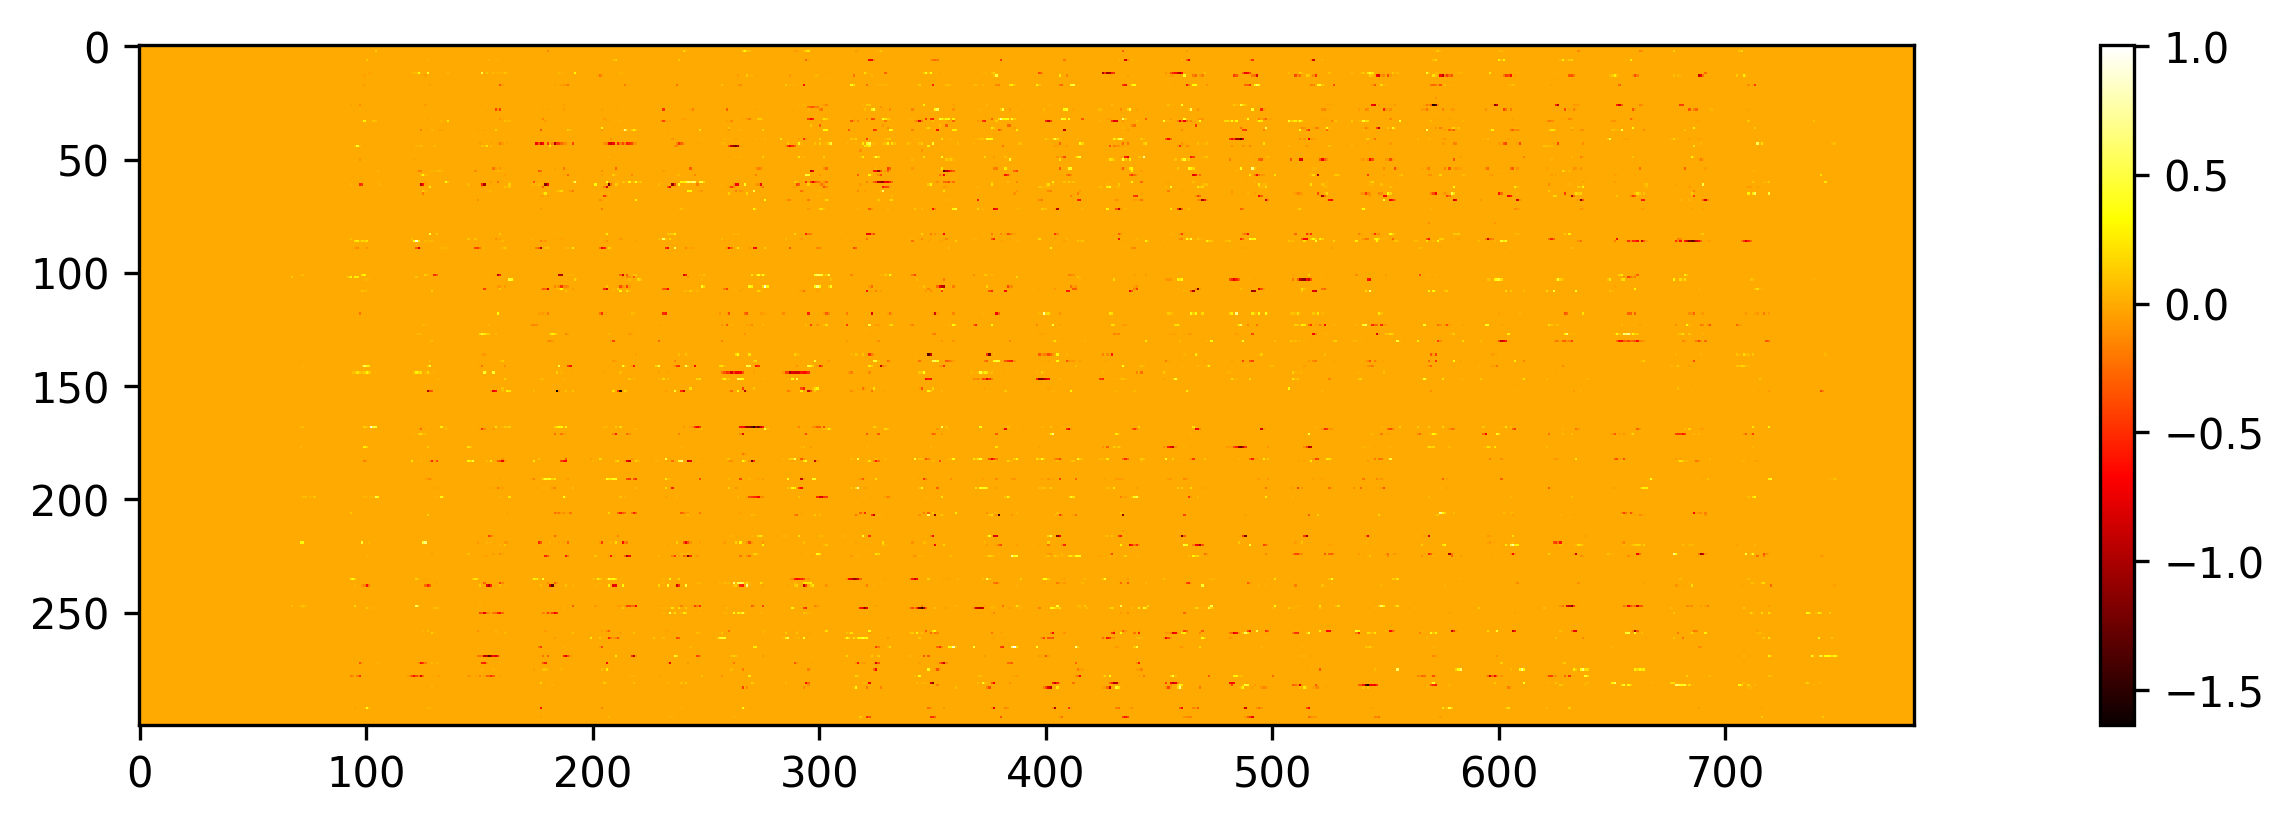

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 3
rcParams['figure.dpi'] = 300


log_alpha = (model.fc1.log_alpha.detach().numpy() < 3).astype(np.float)
W = model.fc1.W.detach().numpy()

plt.imshow(log_alpha * W, cmap='hot', interpolation=None)
plt.colorbar()

(-0.5, 419.5, 419.5, -0.5)

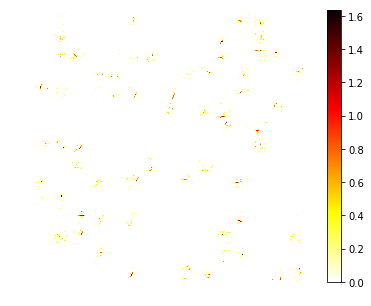

In [13]:
s = 0
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 5

z = np.zeros((28*15, 28*15))

for i in range(15):
    for j in range(15):
        s += 1
        z[i*28:(i+1)*28, j*28:(j+1)*28] =  np.abs((log_alpha * W)[s].reshape(28, 28))
        
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')

# Optional Research Assignment (up to 2 points)

1. Study the model: 
    - How sparsity and accuracy depend on maximum of KL-multiplier (kl_weight)?
    - How quality depends on the initialization of log_sigma (log_sigma)?
    - Study the KL approximation: what if we use the reparametrization trick to obtain an unbiased MC estimate of KL?
2. Compression:
    - What can we do to obtain better compression results with small quality degradation?
    - Propose and eval several options.
3. Study the Local reparametrization trick: 
    - Does it really accelerate convergence?
    - Does variance of gradient decrease?
    
You can do one out of three parts. You need to provide evidence for results e.g., plots, etc.